In [1]:
# Importing relevant libraries
%load_ext lab_black
import warnings
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import math
from scipy import stats

In [2]:
# Loading the data
data_2021 = pd.read_csv("../data/airbnb_listings_2021.csv")
data_2021.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [3]:
# Dropping irrelevant columns and those that are unethical to use
data_2021.drop(
    [
        "id",
        "host_name",
        "last_review",
        "license",
        "name",
        "host_id",
        "number_of_reviews",
        "reviews_per_month",
        "number_of_reviews_ltm",
    ],
    axis=1,
    inplace=True,
)

In [4]:
# Replacing the missing values for numerical columns with mean and mode
data_2021["price"] = data_2021["price"].fillna(data_2021["price"].mean())
data_2021["minimum_nights"] = data_2021["minimum_nights"].fillna(
    data_2021["minimum_nights"].mean()
)
data_2021["calculated_host_listings_count"] = data_2021[
    "calculated_host_listings_count"
].fillna(data_2021["calculated_host_listings_count"].mean())
data_2021["availability_365"] = data_2021["availability_365"].fillna(
    data_2021["availability_365"].mean()
)
data_2021["neighbourhood_group"] = data_2021["neighbourhood_group"].fillna(
    data_2021["neighbourhood_group"].mode()[0]
)
data_2021.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [5]:
# label encoding categorical columns
label_encoder = LabelEncoder()
data_2021["neighbourhood_group"] = label_encoder.fit_transform(
    data_2021["neighbourhood_group"]
)
data_2021["neighbourhood"] = label_encoder.fit_transform(data_2021["neighbourhood"])
data_2021["room_type"] = label_encoder.fit_transform(data_2021["room_type"])

In [6]:
# Remove outliers
z_scores = stats.zscore(data_2021)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
new_data = data_2021[filtered_entries]

In [7]:
# Scaling the data
scaler = StandardScaler()
# scaler.fit(new_data)
scaled_features = scaler.fit_transform(new_data)
scaled_features_data = pd.DataFrame(
    scaled_features, index=new_data.index, columns=new_data.columns
)

In [8]:
# Creating train and test data
X = scaled_features_data.drop("price", axis=1)
y = scaled_features_data["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# checking for multicollinearity
# VIF starts at 1 and has no upper limit
# VIF = 1, no correlation between the independent variable and the other variables
# VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))
]

print(vif_data)

                          feature       VIF
0             neighbourhood_group  1.814112
1                   neighbourhood  1.132051
2                        latitude  1.868160
3                       longitude  1.117422
4                       room_type  1.053117
5                  minimum_nights  1.051471
6  calculated_host_listings_count  1.082225
7                availability_365  1.103643


In [10]:
# Linear Regression perfomance based on RMSE, MSE, R2 and AdjR2
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score", r2_score(y_test, y_pred))
print(
    "Adj R^2 value:",
    1
    - (1 - regressor.score(X_test, y_test))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1),
)

MSE 0.7611271327844533
RMSE 0.8724260041885806
R2 Score 0.25389085014961776
Adj R^2 value: 0.25288514278671914


In [14]:
# Regression output
X = sm.add_constant(X)
stats_model = sm.OLS(y, X)
results = stats_model.fit()
print("r2/variance : ", results.rsquared)
print(results.summary())

r2/variance :  0.2430502493735085
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1192.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        19:24:36   Log-Likelihood:                -38029.
No. Observations:               29717   AIC:                         7.608e+04
Df Residuals:                   29708   BIC:                         7.615e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

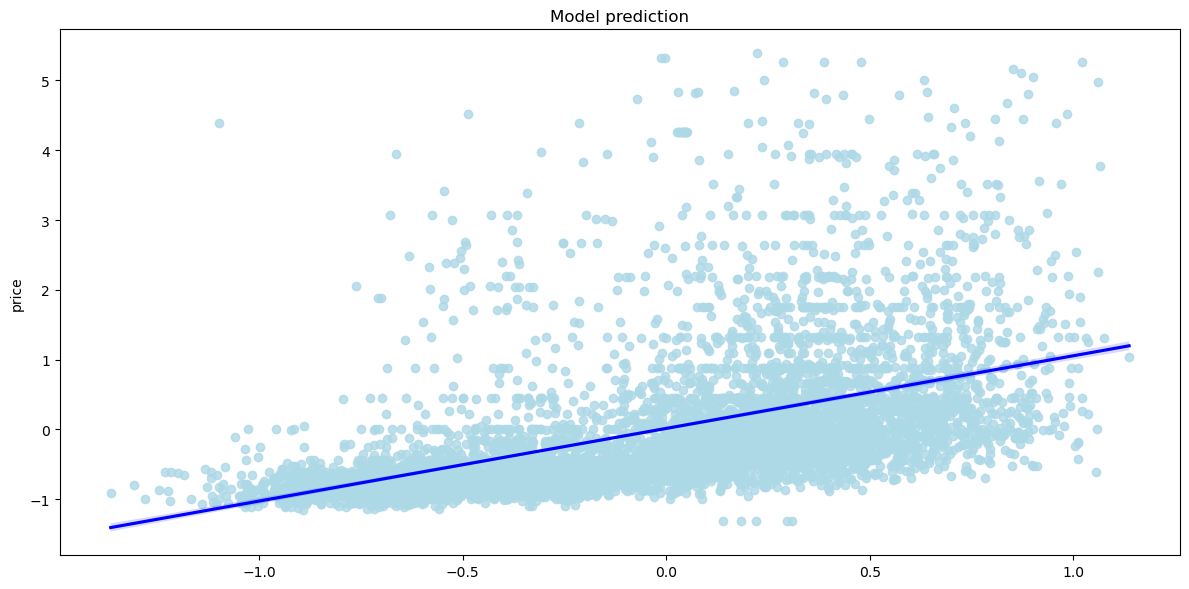

In [16]:
# model prediction
# price prediction
linear_predictions = regressor.predict(X_test)
fig = plt.figure(figsize=(12, 6))
sns.regplot(
    y=y_test,
    x=linear_predictions,
    scatter_kws={"color": "lightblue"},
    line_kws={"color": "blue"},
)
plt.title("Model prediction")


fig.tight_layout()
os.makedirs("../artifacts", exist_ok=True)
fig.savefig("../artifacts/linear_predictions.png")

In [18]:
# Actual vs. predicted values
error = pd.DataFrame(
    {
        "Actual Values": np.array(y_test).flatten(),
        "Predicted Values": linear_predictions.flatten(),
    }
)
error.head(10)

,Actual Values,Predicted Values
0,-0.830115,-1.128742
1,-0.724827,-0.289586
2,-0.128194,0.216087
3,1.652930,0.280602
4,0.687789,0.681081
5,0.442116,0.166137
6,0.161348,0.575465
7,-0.654635,-0.052198
8,-0.215935,0.243282
9,-0.259805,0.299526
